# 2702262652 / Richard Dean Tanjaya

In [1]:
#!pip install xgboost

In [2]:
# Basic library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing library
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Model library
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Model saving
import joblib

In [3]:
df = pd.read_csv('Dataset_B_hotel.csv')

display(df.head())
print(f'Rows : {df.shape[0]} x Cols : {df.shape[1]}')

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0.0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0.0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0.0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0.0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0.0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


Rows : 36275 x Cols : 19


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     35368 non-null  object 
 6   required_car_parking_space            35005 non-null  float64
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

# **a) Data Cleaning & EDA**

In [5]:
df[df.duplicated()].any()

Booking_ID                              False
no_of_adults                            False
no_of_children                          False
no_of_weekend_nights                    False
no_of_week_nights                       False
type_of_meal_plan                       False
required_car_parking_space              False
room_type_reserved                      False
lead_time                               False
arrival_year                            False
arrival_month                           False
arrival_date                            False
market_segment_type                     False
repeated_guest                          False
no_of_previous_cancellations            False
no_of_previous_bookings_not_canceled    False
avg_price_per_room                      False
no_of_special_requests                  False
booking_status                          False
dtype: bool

In [6]:
df.isnull().sum()

Booking_ID                                 0
no_of_adults                               0
no_of_children                             0
no_of_weekend_nights                       0
no_of_week_nights                          0
type_of_meal_plan                        907
required_car_parking_space              1270
room_type_reserved                         0
lead_time                                  0
arrival_year                               0
arrival_month                              0
arrival_date                               0
market_segment_type                        0
repeated_guest                             0
no_of_previous_cancellations               0
no_of_previous_bookings_not_canceled       0
avg_price_per_room                      1632
no_of_special_requests                     0
booking_status                             0
dtype: int64

bisa dilihat bahwa duplicate value tidak ada, tetapi null value ada. Hal ini berarti fokus utama kita adalah untuk mengimputasi null value ini menggunakan metode-metode tertentu

## **1.1) Delete Useless Columns**

In [7]:
df['arrival_date'].value_counts().head(5)

arrival_date
13    1358
17    1345
2     1331
4     1327
19    1327
Name: count, dtype: int64

In [8]:
df = df.drop(columns = ['Booking_ID', 'arrival_date'])

Column ['Booking_ID', 'arrival_date'] dilakukan deletion karena kalau Booking_ID tidak memiliki peran apapun terhadap pembelajaran model, sementara untuk arrival_date dilakukan karena tidak memiliki konteksnya yang terlalu berperan karena terlalu banyak. Dibandingkan dengan Tahun ataupun bulan yang masih bisa digunakan, kalau arrival_date tidak terlalu berpengaruh

## **1.1) Data Splitting**

In [9]:
X = df.drop(['booking_status'], axis = 1)
y = df['booking_status']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print('Train-set Dimension: ', X_train.shape)
print('Test-set Dimension: ', X_test.shape)

Train-set Dimension:  (29020, 16)
Test-set Dimension:  (7255, 16)


Kita lakukan splitting terlebih dahulu sebelum melakukan imputasi null value ataupun lainnya, karena kalau tidak dapat terjadi yang namanya data leakage. Kondisi itu terjadi ketika kita mengimputasi null value kita menggunakan data keseluruhan kita, hal ini menyebabkan model tidak mempelajari, melainkan menghapal karena ada data dari test set yang bocor

## **1.2) Missing Value Handlling**

In [11]:
num_cols = X_train.select_dtypes(include = ['float', 'int']).columns.to_list()
object_cols = X_train.select_dtypes(include = 'object').columns.to_list()

In [12]:
missing_num_cols = X_train[num_cols].isnull().sum()[X_train[num_cols].isnull().sum() > 0].index.to_list()
missing_object_cols = X_test[object_cols].isnull().sum()[X_test[object_cols].isnull().sum() > 0].index.to_list()

display(missing_num_cols, missing_object_cols)

['required_car_parking_space', 'avg_price_per_room']

['type_of_meal_plan']

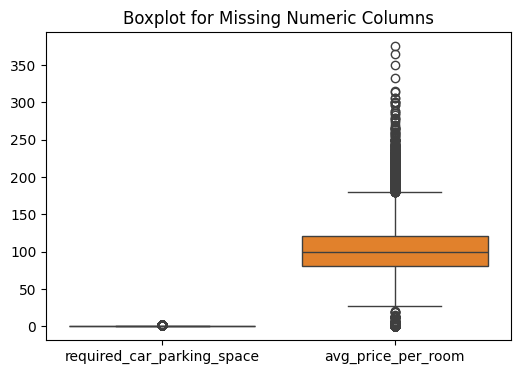

In [13]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=X_train[missing_num_cols])
plt.title('Boxplot for Missing Numeric Columns')
plt.xticks()
plt.show()

Display boxplot untuk menentukan apakah kita mengimputasi null value dengan mean atau median, berdasarkan plotting tersebut karena ada outlier, maka kita melakukan imputasi dengan median

In [14]:
X_train['required_car_parking_space'].value_counts()

required_car_parking_space
0.0    27081
1.0      900
Name: count, dtype: int64

In [15]:
for col in missing_num_cols:
    median_value = X_train[col].median()
    X_train[col] = X_train[col].fillna(median_value)
    X_test[col] = X_test[col].fillna(median_value)

for col in missing_object_cols:
    most_freq = X_train[col].value_counts().idxmax()
    X_train[col] = X_train[col].fillna(most_freq)
    X_test[col] = X_test[col].fillna(most_freq)

Melakukan imputasi median ke column numerical dan imputasi frekuensi terbanyak ke column object, kalau untuk column object memang menjadi standar umum saja untuk melakukan imputasi berdasarkan modus

In [16]:
X_train.isnull().sum()

no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
dtype: int64

Selalu print ulang df.isnull().sum() untuk memastikan apakah kita sudah berhasil mengimputasi atau tidak, karena terkadang bisa saja kita salah dalam code atau penulisan nama column yang tidak menyebabkan error, sehingga efeknya data tidak terimputasi

## **1.3) EDA**

In [17]:
outlier = []
no_outlier = []
def plot_dist(df, col):
    fig, axs = plt.subplots(ncols = 2, nrows = 1,figsize = (8, 3))

    # Plot Histogram
    sns.histplot(df[col], ax = axs[0], bins=30)
    axs[0].set_title(f"Histogram {col}")
    axs[0].axvline(df[col].mean(), color = 'red', linestyle = 'dashed', label = 'mean')
    axs[0].axvline(df[col].median(), color = 'green', linestyle = 'dashed', label = 'median')
    axs[0].legend()

    # Plot Boxplot
    sns.boxplot(y=df[col], ax =  axs[1])
    axs[1].set_title(f"Boxplot {col}")

    plt.show()

    # Print Skewness
    print('Skewness :', df[col].skew())
    if -0.1 <= df[col].skew() <= 0.1:
        print("Column |{}| normal distribution".format(col))
    elif df[col].skew() > 0.1:
        print("Column |{}| right skewed".format(col))
    elif df[col].skew() < -0.1:
        print("Column |{}| left skewed".format(col))

    # Outlier Detection using IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col].tolist()

    if outliers:
        print(f"⚠️ Outliers detected in '{col}': {outliers[:5]}")
        outlier.append(col)
    else:
        print(f"✅ No outliers detected in '{col}'.")
        no_outlier.append(col)
    print("========================================================================================")

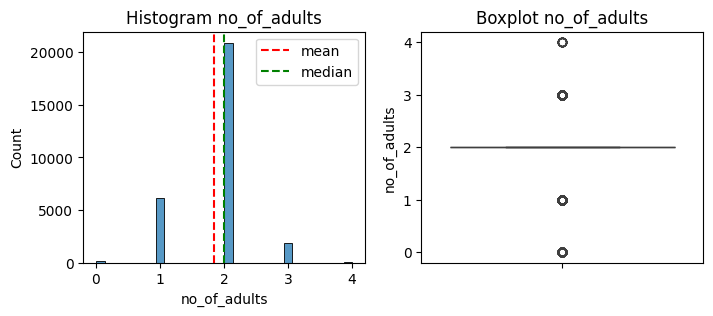

Skewness : -0.3408381780050516
Column |no_of_adults| left skewed
⚠️ Outliers detected in 'no_of_adults': [1, 1, 1, 3, 1]


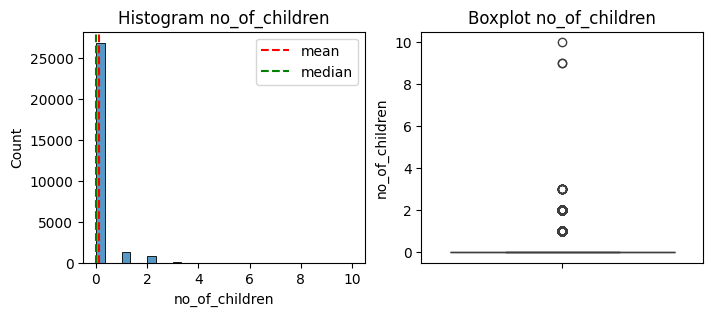

Skewness : 4.844411575850196
Column |no_of_children| right skewed
⚠️ Outliers detected in 'no_of_children': [1, 1, 1, 2, 2]


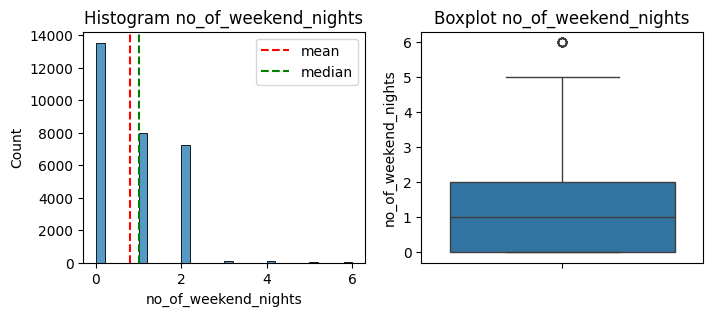

Skewness : 0.7194262173155715
Column |no_of_weekend_nights| right skewed
⚠️ Outliers detected in 'no_of_weekend_nights': [6, 6, 6, 6, 6]


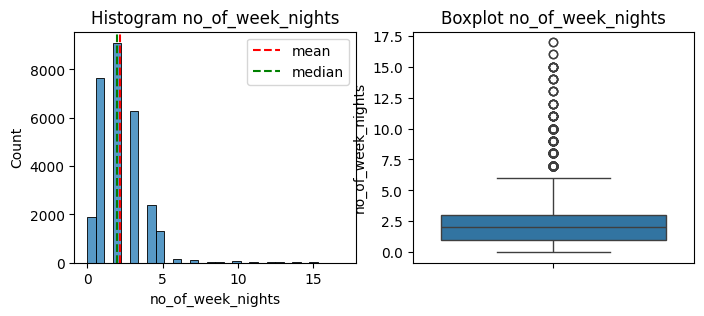

Skewness : 1.542808091718338
Column |no_of_week_nights| right skewed
⚠️ Outliers detected in 'no_of_week_nights': [11, 7, 8, 13, 8]


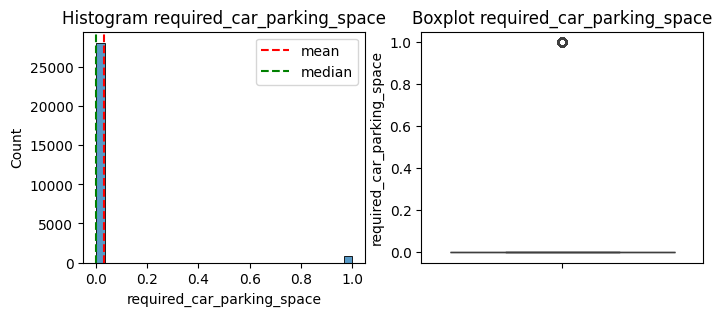

Skewness : 5.4110513695138485
Column |required_car_parking_space| right skewed
⚠️ Outliers detected in 'required_car_parking_space': [1.0, 1.0, 1.0, 1.0, 1.0]


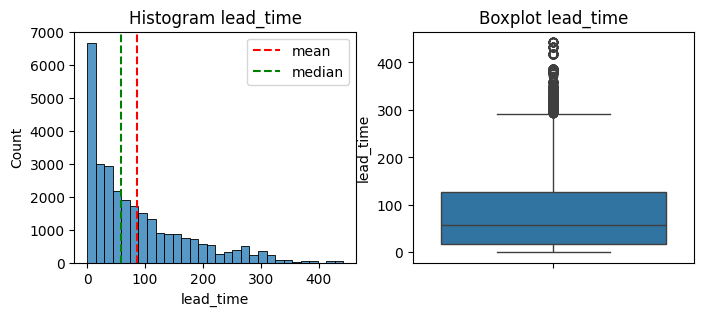

Skewness : 1.289143998432937
Column |lead_time| right skewed
⚠️ Outliers detected in 'lead_time': [433, 359, 301, 346, 361]


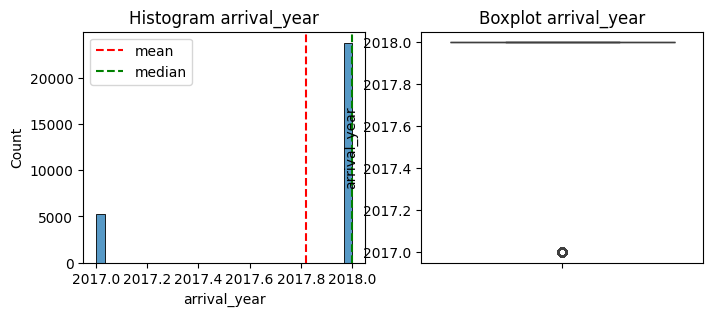

Skewness : -1.6697735533409426
Column |arrival_year| left skewed
⚠️ Outliers detected in 'arrival_year': [2017, 2017, 2017, 2017, 2017]


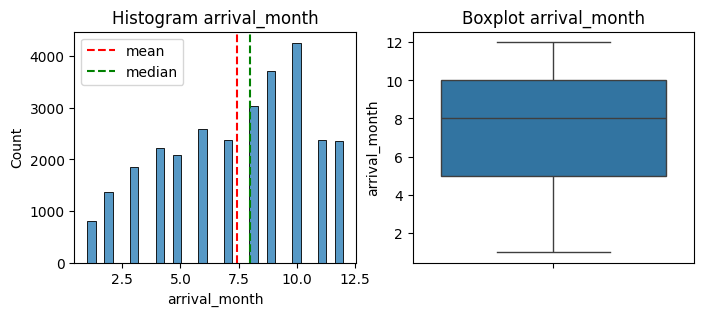

Skewness : -0.34671105911372574
Column |arrival_month| left skewed
✅ No outliers detected in 'arrival_month'.


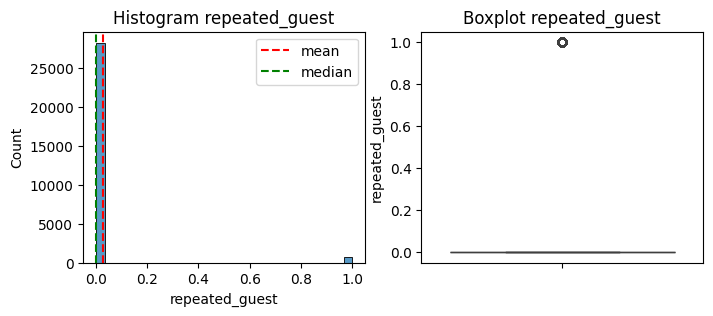

Skewness : 5.985561991635112
Column |repeated_guest| right skewed
⚠️ Outliers detected in 'repeated_guest': [1, 1, 1, 1, 1]


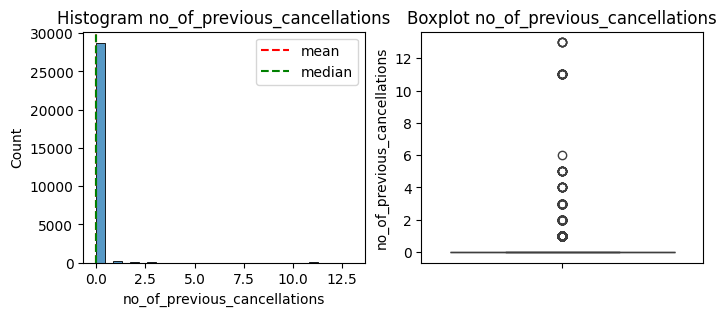

Skewness : 24.94098438237305
Column |no_of_previous_cancellations| right skewed
⚠️ Outliers detected in 'no_of_previous_cancellations': [1, 1, 1, 1, 1]


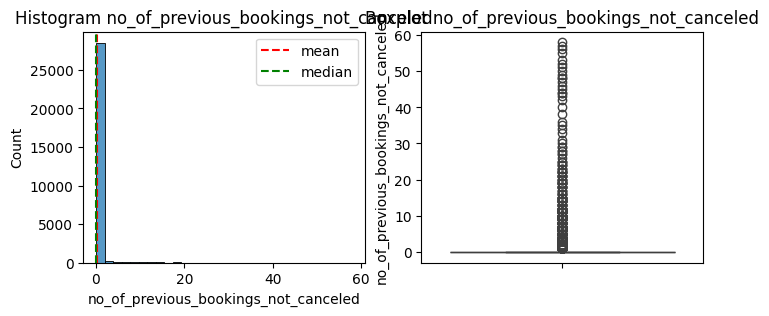

Skewness : 19.509732675794666
Column |no_of_previous_bookings_not_canceled| right skewed
⚠️ Outliers detected in 'no_of_previous_bookings_not_canceled': [17, 3, 10, 1, 2]


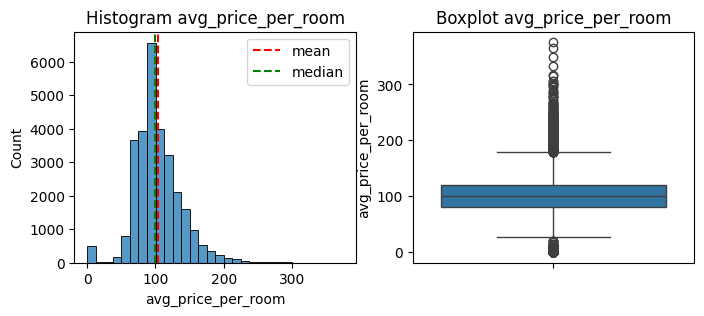

Skewness : 0.6428424856993477
Column |avg_price_per_room| right skewed
⚠️ Outliers detected in 'avg_price_per_room': [180.0, 186.3, 0.0, 185.0, 220.0]


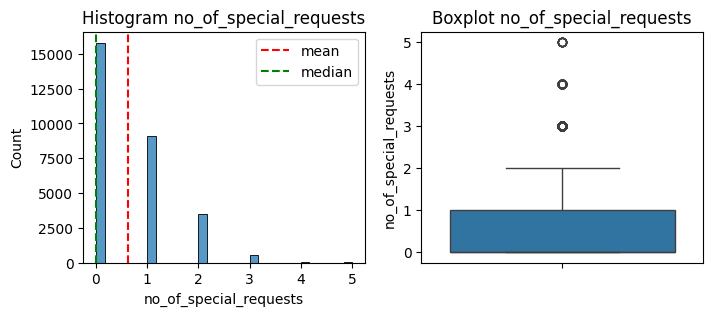

Skewness : 1.1504482948802144
Column |no_of_special_requests| right skewed
⚠️ Outliers detected in 'no_of_special_requests': [4, 3, 3, 3, 3]


In [18]:
for col in num_cols:
    plot_dist(X_train, col)

In [19]:
print(f'Outlers : {outlier}')
print(f'No Outliers : {no_outlier}')

Outlers : ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'required_car_parking_space', 'lead_time', 'arrival_year', 'repeated_guest', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'avg_price_per_room', 'no_of_special_requests']
No Outliers : ['arrival_month']


Function plotting diatas berguna untuk mengetahui apakah data kita memiliki skewness dan outlier. Fokus utama kita adalah pada outliernya, karena data yang memiliki outlier harus kita group ke variable yang sama supaya nanti bisa dilakukan robust scaling, sementara untuk data yang tidak memiliki outlier bisa dilakukan standard scaling

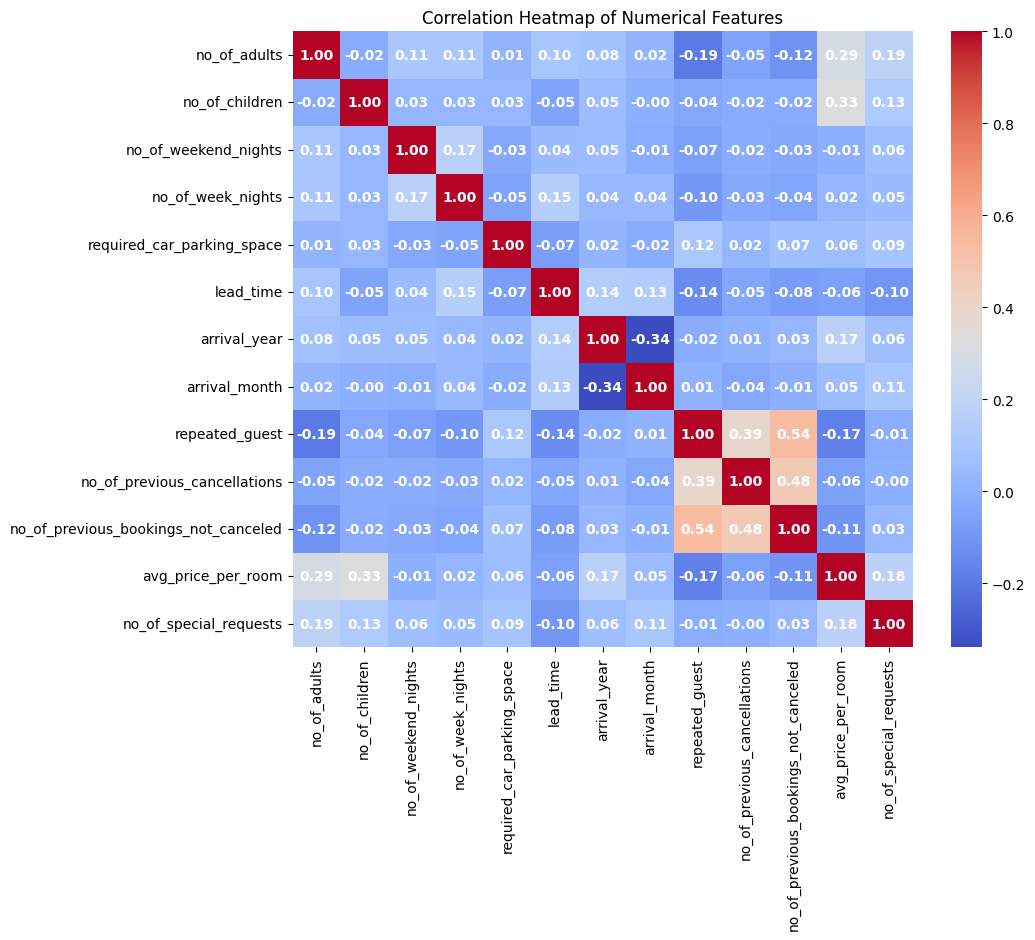

In [20]:
numeric_train = X_train.select_dtypes(include = ['float', 'int'])
corr = numeric_train.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot = True,
            cmap='coolwarm',
            fmt = '.2f',
            annot_kws = {'size': 10, 'weight':'bold', 'color':'white'})
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

Secara overall, data kita memiliki korelasi yang tidak terlalu signifikan antar fitur. Meskipun begitu, kita tidak boleh melakukan dropping column yang memiliki nilai korelasi yang rendah, karena bisa saja model bisa menangkap informasi dari korelasi tersebut meskipun kecil. Ditambah lagi, jangan pernah lakukan PCA (Principal Component Analysis) terhadap data seperti kita, karena PCA bertujuan untuk mengurangi dimensi dataframe yang terlalu berlebihan tetapi memiliki drawback informasi yang hilang. Selain dari itu, dataframe punya kita bisa dilihat tidak terlalu banyak meskipun belum dilakukan OneHotEncoding, tetapi balik lagi, untuk mempertahankan semua informasi yang ada sebaiknya tidak melakukan PCA

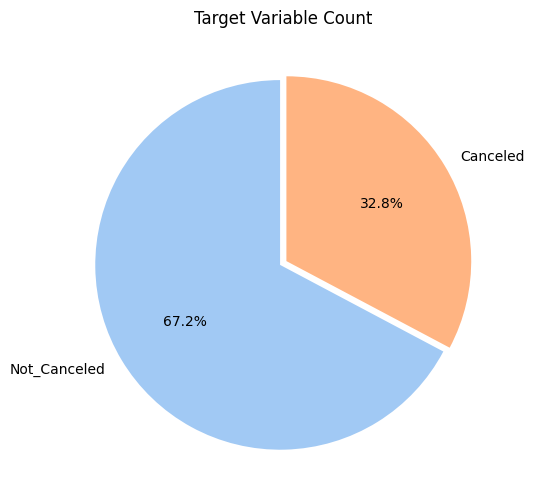

In [21]:
data = df['booking_status'].value_counts()
label = data.index

colors = sns.color_palette('pastel', len(label))

plt.figure(figsize = (8,6))
plt.pie(data, labels = label, autopct = '%1.1f%%',
        explode = [0.02] * len(label),
        startangle = 90,
        colors = colors)
plt.title('Target Variable Count')
plt.show()

bisa dilihat bahwa column "booking_status" atau y target kita sangat imbalance, dari plotting ini bisa kita jadikan sebagai informasi yang dimana kita akan melakukan duplikasi data. Tujuan dari duplikasi data adalah supaya model tidak terlalu bias dalam training, sehingga hasilnya dapat sesuai dengan apa yang kita inginkan

# **b) Feature Engineering**

In [22]:
ohe_cols = object_cols
scaler_cols = no_outlier
robust_cols = outlier

transformer = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), scaler_cols),
        ('robust', RobustScaler(), robust_cols),
        ('ohe', OneHotEncoder(handle_unknown = 'ignore'), ohe_cols)
    ]
)

X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

Disini saya gunakan columnTransformer sebagai cara untuk mempersingkat Feature Engineering, jadi hal ini membuat hanya dengan 1 funcuon saya bisa melakukan standardScaler, robustScaler, dan OHE secara bersamaan. Ditambah lagi, ColumnTransformer memiliki functionnya sendiri yang dapat mempermudah pengambilan nama column hasil transformasi, yang dapat digunakan untuk melihat mana fitur yang paling berpengaruh dalam model

In [23]:
ohe_feature_names = transformer.named_transformers_['ohe'].get_feature_names_out(ohe_cols)
all_feature_names = scaler_cols + robust_cols + list(ohe_feature_names)

X_train_df = pd.DataFrame(X_train, columns=all_feature_names)
X_train_df.head()

,arrival_month,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,repeated_guest,no_of_previous_cancellations,...,room_type_reserved_Room_Type 3,room_type_reserved_Room_Type 4,room_type_reserved_Room_Type 5,room_type_reserved_Room_Type 6,room_type_reserved_Room_Type 7,market_segment_type_Aviation,market_segment_type_Complementary,market_segment_type_Corporate,market_segment_type_Offline,market_segment_type_Online
0,0.844278,0.0,1.0,0.5,-0.5,0.0,-0.290909,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.136113,0.0,1.0,0.0,-0.5,0.0,0.363636,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.517481,0.0,0.0,-0.5,0.5,0.0,3.409091,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.190684,0.0,0.0,0.5,1.5,0.0,1.245455,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.462910,-1.0,0.0,-0.5,0.0,0.0,1.181818,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Disini saya cuman melakukan penggabungan value dan column hasil dari ColumnTransformer untuk di view saja, untuk memastikan apakah hasilnya benar atau tidak

In [24]:
label_map = {'Canceled': 0, 'Not_Canceled': 1}

y_train = y_train.map(label_map)
y_test = y_test.map(label_map)

Pada bagian ini dilakukan mapping terhadap y target, karena dalam penggunaan XGBoost tidak diperbolehkan ketika y targetnya masih categorical. Oleh karena itu saya mengubahnya menjadi [0, 1] dengan mapping

In [25]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

SMOTE disini berperan seperti duplikasi data, tetapi duplikasinya bukan benar-benar duplikasi. Jadi dia itu seperti peniruan dari data originial, misal di y target "Canceled" terdapat data [1, 2, 4], dia tidak serta merta ambil duplikasi dari salah satu aja, melainkan meniru saja supaya dapat terbentuk data replikasinya sendiri, kalau dalam contoh kasus kita dia bisa meniru dan membuat datanya menjadi [1, 2, 3, 4].

# **c) Model building**

## **3.1) Basic Model**

In [26]:
models = {
    "Random Forest": RandomForestClassifier(random_state = 42),
    "XGBoost": XGBClassifier(random_state = 42),
}

Saya menggunakan dictionary untuk mempermudah running Random Forest dan XGBoost supaya bisa dalam 1 cell yang sama

In [27]:
for model_name, model in models.items():
    print(f"# Model: {model_name}\n")

    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    print("Classification Report Train-set:\n", classification_report(y_train, y_pred_train))
    print("Classification Report Test-set:\n", classification_report(y_test, y_pred_test))
    print("=" * 80)

# Model: Random Forest

Classification Report Train-set:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     19551
           1       0.99      1.00      0.99     19551

    accuracy                           0.99     39102
   macro avg       0.99      0.99      0.99     39102
weighted avg       0.99      0.99      0.99     39102

Classification Report Test-set:
               precision    recall  f1-score   support

           0       0.86      0.83      0.84      2416
           1       0.92      0.93      0.92      4839

    accuracy                           0.90      7255
   macro avg       0.89      0.88      0.88      7255
weighted avg       0.90      0.90      0.90      7255

# Model: XGBoost

Classification Report Train-set:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92     19551
           1       0.92      0.93      0.92     19551

    accuracy                           

Hasil dari fitting tersebut, dapat dilihat bahwa secara overall Random Forest sangat bagus tetapi sangat overfitting. Kalau dibandingkan dengan XGBoost, dia menghasilkan train 92% dan test 88%, sangat konsisten dan tidak overfitting. Dari informasi ini, belum bisa disimpulkan siapa model terbaik, kita harus melewati fase Fine Tuning terlebih dahulu

## **3.2) Model Fine Tuning**

In [28]:
RF = RandomForestClassifier(random_state = 42)

RF_paramgrid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 4, 5],
    'max_features': ['sqrt', 'log2']
}

RF_grid = GridSearchCV(RF, RF_paramgrid, cv=5, scoring='accuracy', n_jobs=-1)
RF_grid.fit(X_train, y_train)
print("Best parameters for Random Forest:\n", RF_grid.best_params_)
print('Best Score Random Forest:', RF_grid.best_score_)

Best parameters for Random Forest:
 {'max_depth': 5, 'max_features': 'log2', 'n_estimators': 200}
Best Score Random Forest: 0.812771621815618


In [29]:
xgb = XGBClassifier(random_state=42)

xgb_paramgrid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2]
}

xgb_grid = GridSearchCV(xgb, xgb_paramgrid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
xgb_grid.fit(X_train, y_train)

print("Best parameters for XGBoost:\n", xgb_grid.best_params_)
print("Best Score XGBoost:", xgb_grid.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters for XGBoost:
 {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
Best Score XGBoost: 0.9000578742195499


Kedua model diberikan Hyperparamet tuning yang relatif sama dengan value yang sama, supaya kita bisa membandingkan model mana yang memiliki performa lebih bagus

In [30]:
best_params_RF = RF_grid.best_params_
best_model_RF = RandomForestClassifier(random_state = 42)
best_model_RF.set_params(**best_params_RF)

best_model_RF.fit(X_train, y_train)

y_pred_train_RF = best_model_RF.predict(X_train)
y_pred_test_RF = best_model_RF.predict(X_test)

print('Classification Report Train-set:\n', classification_report(y_train, y_pred_train_RF))
print(f"Accuracy Score Train-set: {accuracy_score(y_train, y_pred_train_RF):.4f}\n")

print('Classification Report Test-set:\n', classification_report(y_test, y_pred_test_RF))
print(f"Accuracy Score Test-set: {accuracy_score(y_test, y_pred_test_RF):.4f}")

Classification Report Train-set:
               precision    recall  f1-score   support

           0       0.83      0.80      0.81     19551
           1       0.81      0.83      0.82     19551

    accuracy                           0.82     39102
   macro avg       0.82      0.82      0.82     39102
weighted avg       0.82      0.82      0.82     39102

Accuracy Score Train-set: 0.8164

Classification Report Test-set:
               precision    recall  f1-score   support

           0       0.71      0.79      0.75      2416
           1       0.89      0.84      0.86      4839

    accuracy                           0.82      7255
   macro avg       0.80      0.81      0.80      7255
weighted avg       0.83      0.82      0.82      7255

Accuracy Score Test-set: 0.8221


Hasil dari Random Forest lumayan bagus, dia menghasilkan overfitting seperti sebelumnya tetapi malah terjadi penurunan jauh menjadi train 82% dan test 82%. Hal ini tetap menunjukan bahwa modelnya sangat stabil dalam membuat prediksi, tidak seperti sebelumnya

In [31]:
best_params_XGB = xgb_grid.best_params_
best_model_XGB = XGBClassifier(random_state = 42)
best_model_XGB.set_params(**best_params_XGB)

best_model_XGB.fit(X_train, y_train)

y_pred_train_XGB = best_model_XGB.predict(X_train)
y_pred_test_XGB = best_model_XGB.predict(X_test)

print('Classification Report Train-set:\n', classification_report(y_train, y_pred_train_XGB))
print(f"Accuracy Score Train-set: {accuracy_score(y_train, y_pred_train_XGB):.4f}\n")

print('Classification Report Test-set:\n', classification_report(y_test, y_pred_test_XGB))
print(f"Accuracy Score Test-set: {accuracy_score(y_test, y_pred_test_XGB):.4f}")

Classification Report Train-set:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92     19551
           1       0.91      0.93      0.92     19551

    accuracy                           0.92     39102
   macro avg       0.92      0.92      0.92     39102
weighted avg       0.92      0.92      0.92     39102

Accuracy Score Train-set: 0.9189

Classification Report Test-set:
               precision    recall  f1-score   support

           0       0.83      0.82      0.82      2416
           1       0.91      0.92      0.91      4839

    accuracy                           0.88      7255
   macro avg       0.87      0.87      0.87      7255
weighted avg       0.88      0.88      0.88      7255

Accuracy Score Test-set: 0.8823


Model XGBoost ini sangat baik dan konsisten, dari hasil percobaan sebelumnya kita melihat dia menyentuh akurasi train 92% dan test 88%, setelah dilakukan tuning tidak ada perubahan yang signifikan, hal ini berarti model XGBoost sangat baik dalam melakukan prediksi. Model ini tidak terjadi overfitting ataupun underfitting dan kalau secara performa dia lebih unggul jauh daripada Random Forest. Oleh karena itu dapat disimpulkan bahwa model inilah yang menjadi Best model kita

## **3.2) Model Evaluation**

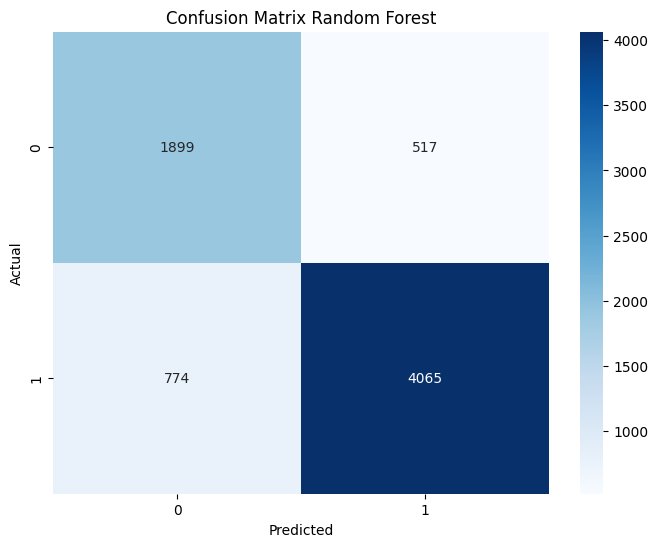

In [32]:
cm = confusion_matrix(y_test, y_pred_test_RF)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Random Forest')
plt.show()

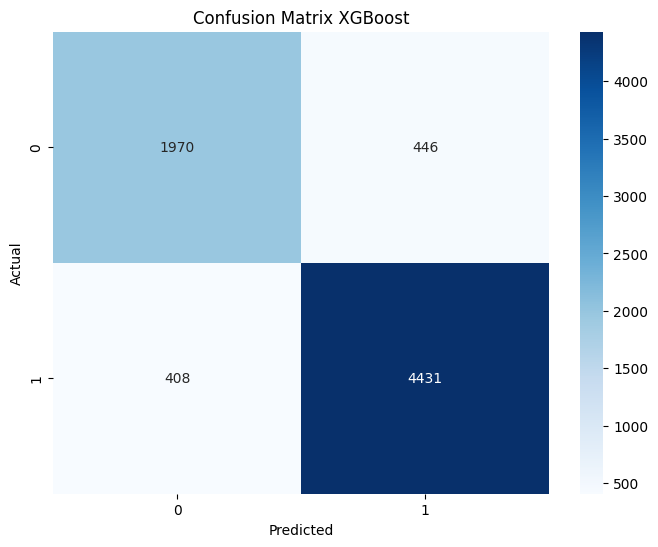

In [33]:
cm = confusion_matrix(y_test, y_pred_test_XGB)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix XGBoost')
plt.show()

Dari Confusion matrix bisa dilihat bahwa XGBoost memiliki sekitar 800 salah prediksi class, dibandinkan dengan random forest ada sekitar 1200 kesalahan prediksi. Dari Ditambah lagi dari sisi Random Forest kesalahan prediksinya sangat imbalance, tidak merata. Oleh karena itu XGBoost lebih bagus

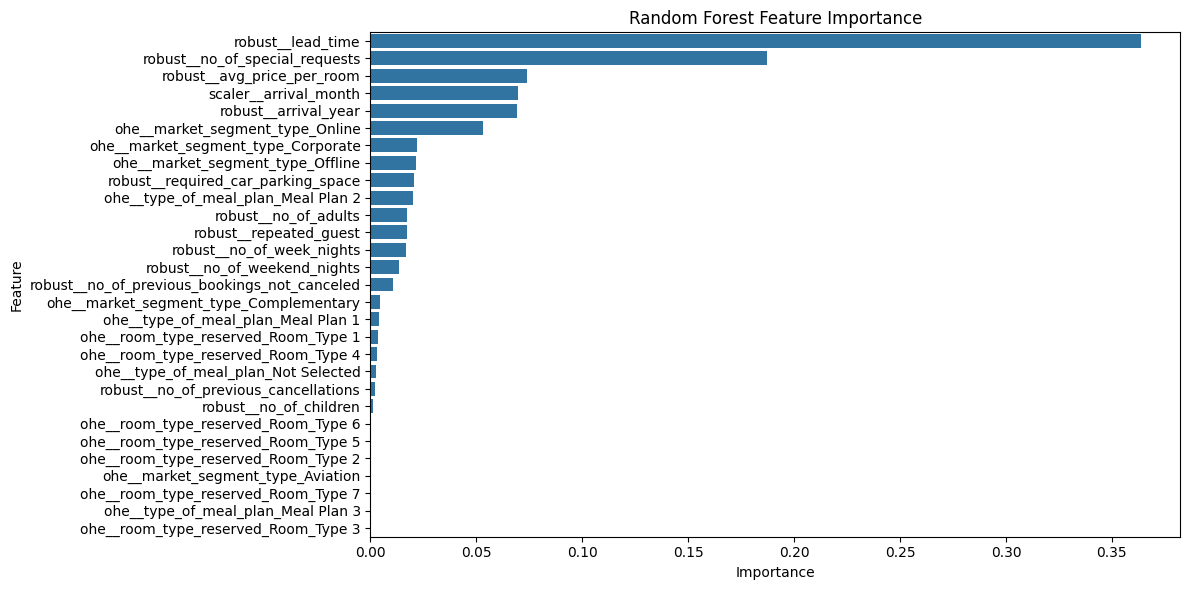

In [34]:
plt.figure(figsize=(12, 6))
feature_importance = pd.DataFrame({
    'Feature': transformer.get_feature_names_out(),
    'Importance': best_model_RF.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

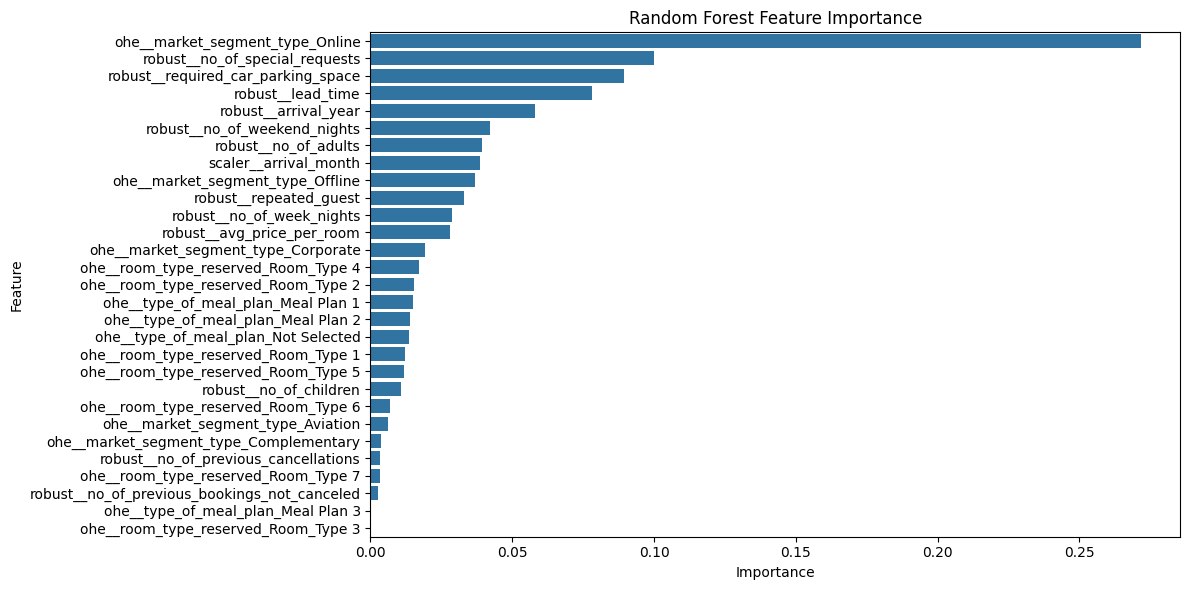

In [35]:
plt.figure(figsize=(12, 6))
feature_importance = pd.DataFrame({
    'Feature': transformer.get_feature_names_out(),
    'Importance': best_model_XGB.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

Ini hanya visualisasi untuk melihat fitur mana yang memiliki peran penting dalam menghasilkan output. Kalau dari Random Forest bisa dilihat bahwa "lead time" sangat mempengaruhinya dengan 35% importance, sementara XGBoost adalah "Market Segment Type Online" dengan 25% Importance. Dalam membuat sebuah model kita tidak mau importance yang terlalu jauh mempengaruhi hasilnya, apalagi kasus Random Forest mencapai 35% tentu sangat tidak ideal. Oleh karena itu terbukti lagi bahwa model XGBoost sangat bagus dipilih sebagai Best Model kita

# **d) Save Model**

In [36]:
joblib.dump(best_model_XGB, "best_model.pkl")
joblib.dump(transformer, "transformer_data.pkl")
print("Model & Transformer saved successfully!")

Model & Transformer saved successfully!


Melakukan saving model supaya dapat digunakan dalam pembuatan aplikasi streamlit supaya lebih mudah